## Notebook to plot the results of the fitting routine tests

In [1]:
import matplotlib.pyplot as plt
import pickle, bz2
import numpy as np
from scipy.interpolate import interp1d

%matplotlib notebook

#### Setup cell

In [2]:
dirsave = '/user/gennaro/Functional_work/Up_the_ramp_myfork/Simulations_results/'
testname = '1'

In [3]:
outputs_file = dirsave+'Test_'+testname+'_out.pbz2'
inputs_file  = dirsave+'Test_'+testname+'_in.pbz2'

#### Restore the svaed files and prepare all variables

In [4]:
with bz2.BZ2File(outputs_file, 'rb') as f:
    dictoload = pickle.load(f)

goodints_l        =  dictoload['goodints_l']
counter_l         =  dictoload['counter_l']
error_l           =  dictoload['error_l']
crloops_counter_l =  dictoload['crloops_counter_l']
outerate_l        =  dictoload['outerate_l']
gof_stat_l        =  dictoload['gof_stat_l']
gof_pval_l        =  dictoload['gof_pval_l']


with bz2.BZ2File(inputs_file, 'rb') as f:
    dictoload = pickle.load(f)

meas_l     = dictoload['meas_l']
myfluxes   = dictoload['myfluxes']
myramps    = dictoload['myramps']
myCRrates  = dictoload['myCRrates']
mybgs      = dictoload['mybgs']
CRdict_l   = dictoload['CRdict_l']
extra_bg_l = dictoload['extra_bg_l']

del(dictoload)

#Unpack the lists to regroup items by ramp

ntest = len(meas_l)//len(myramps)

gi_list  = [np.empty([ntest,mm.group_times.size-1],dtype=np.bool_) for mm in myramps]
CR_list   = [[[] for _ in range(ntest)] for mm in myramps]
meas_list = [[[] for _ in range(ntest)] for mm in myramps]
ebg_list  = [[[] for _ in range(ntest)] for mm in myramps]

counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
error    = np.empty([ntest,len(myfluxes)],dtype=np.int_)
outerate = np.empty([ntest,len(myfluxes)])
crloops_counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
gof_stat = np.empty([ntest,len(myfluxes)])
gof_pval = np.empty([ntest,len(myfluxes)])

for l,(g,C,m,c,e,cc,o,gs,gp,eb) in enumerate(zip(goodints_l,CRdict_l,meas_l,counter_l,error_l,crloops_counter_l,outerate_l,gof_stat_l,gof_pval_l,extra_bg_l)):

    k = l % ntest
    j = l // ntest
    
    counter[k,j]  = c
    error[k,j]    = e
    crloops_counter[k,j] = cc
    outerate[k,j] = o
    gof_stat[k,j] = gs
    gof_pval[k,j] = gp

    gi_list[j][k,:] = g
    CR_list[j][k]   = C
    meas_list[j][k] = m
    ebg_list[j][k]  = eb
    


#### Regroup all the simulated CRhits and check whether they have been detected

In [5]:
allCRtimes = []
allCRcounts = []
allCRdetect = []

ramps_with_CRs = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):

    allCRtimes_p = []
    allCRcounts_p = []
    allCRdetect_p = []
    ramps_with_CRs_p = np.zeros(len(CR_list[j]),dtype=np.bool_)
    
    CRlist_p = CR_list[j]
    for i,dd in enumerate(CRlist_p):
        if dd is not None:
            ramps_with_CRs_p[i] = True
            allCRtimes_p.extend(dd['times'])
            allCRcounts_p.extend(dd['counts'])
            for t in dd['times']:
                hit_intv_idx = np.nonzero(myramp.group_times <= t)[0][-1]
                if gi_list[j][i,hit_intv_idx] ==  False:
                    allCRdetect_p.append(True)
                else:
                    allCRdetect_p.append(False)
    
    
    #print(allCRcounts_p)
    #print(allCRtimes_p)
    allCRtimes.append(np.asarray(allCRtimes_p))
    allCRcounts.append(np.asarray(allCRcounts_p))
    allCRdetect.append(np.asarray(allCRdetect_p))
    ramps_with_CRs.append(ramps_with_CRs_p)


#### Look for false positives in the detected CRhits

In [6]:
CR_false_positives = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    CR_false_positives_p = np.zeros_like(gi_list[j],dtype=np.bool_)
    print('*************')
    print(myflux,myramp.ngroups)
    for i in range(ntest):
        detected_CR_idx = np.nonzero(~gi_list[j][i,:])[0]
        ndet = len(detected_CR_idx)
        if ndet > 0:
            CRdict  = CR_list[j][i]
            for k in range(ndet):
                if CRdict is None:
                    CR_false_positives_p[i,detected_CR_idx[k]] = True
                else:   
                    ts = myramp.group_times[detected_CR_idx[k]]
                    te = myramp.group_times[detected_CR_idx[k]+1]
                    if np.all( (CRdict['times']< ts) | ((CRdict['times']> te))) == True:
                        CR_false_positives_p[i,detected_CR_idx[k]] = True
                    
    print(np.sum(CR_false_positives_p))       
    CR_false_positives.append(CR_false_positives_p)
    

*************
0.05 15
0
*************
4 15
1
*************
64 15
0
*************
0.5 15
1
*************
0.5 15
42
*************
0.5 15
3342
*************
0.5 15
706


### Diagnostic plots

#### Global diagnostics

In [7]:
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [8]:
mm = myramps[0]

mm.nframes

1

<IPython.core.display.Javascript object>


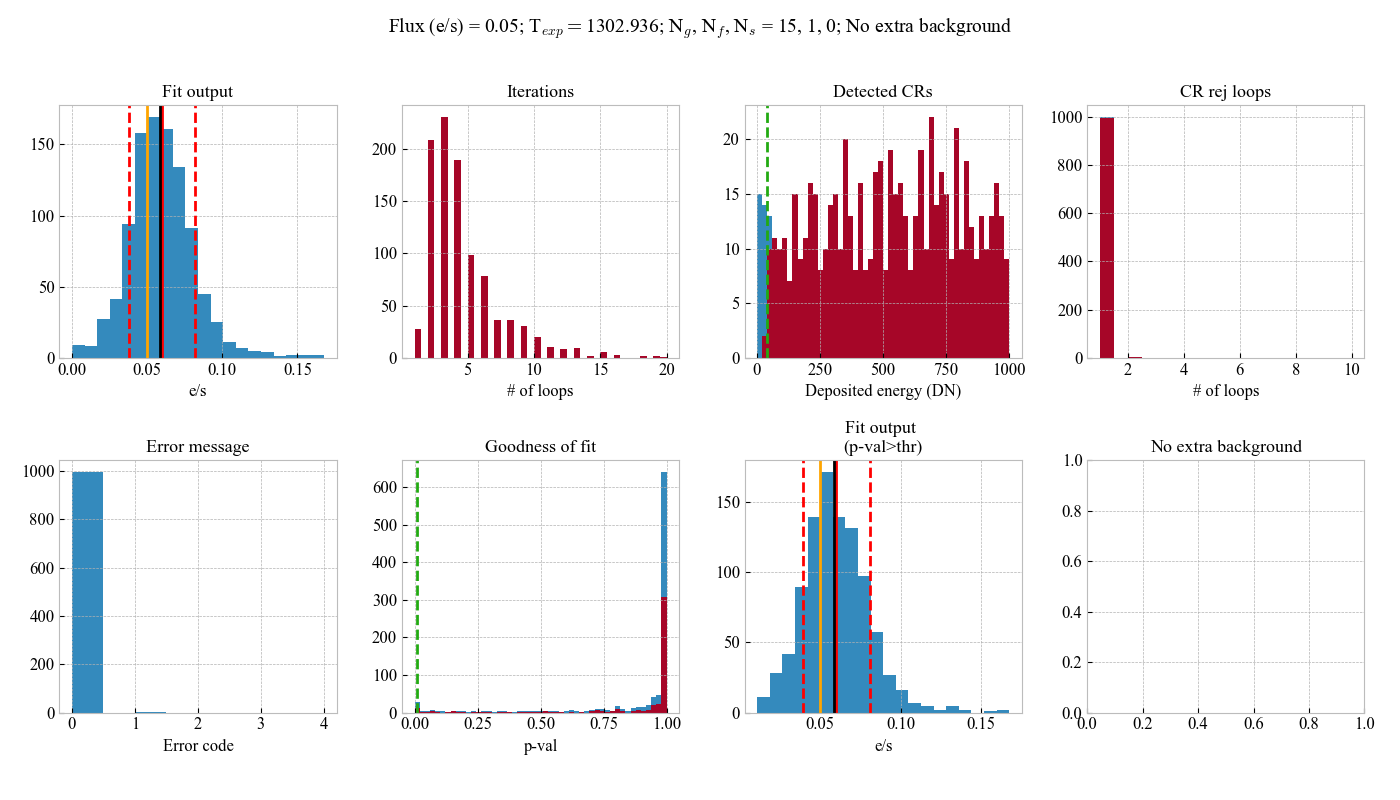

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:117: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


######################
Input flux (e/s): 0.05
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 99.6 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: 12.389,  6.253,  0.181,   13.9
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0062,  0.0031,  0.0001,  0.0069
Standard deviation from "noiseless" counts (e/s):  0.0060
 
Output mean (e/s):  0.0598
Output median (e/s):  0.0583
Output standard deviation (e/s):  0.0218
Rel. % error: : 43.51
Rel. % bias:: 19.52
 
no-CR Output mean (e/s):  0.0569
no-CR Output median (e/s):  0.0561
no-CR Output standard deviation (e/s):  0.0170
no-CR Rel. % error: : 33.99
no-CR Rel. % bias:: 13.79
 
yes-CR Output mean (e/s):  0.0631
yes-CR Output median (e/s):  0.0616
yes-CR Output standard deviation (e/s):  0.0258
yes-CR Rel. % error: : 51.65
yes-CR Rel. % bias:: 26.17
 
Fraction of good fits at  0.010 confidence: 97.5 

<IPython.core.display.Javascript object>


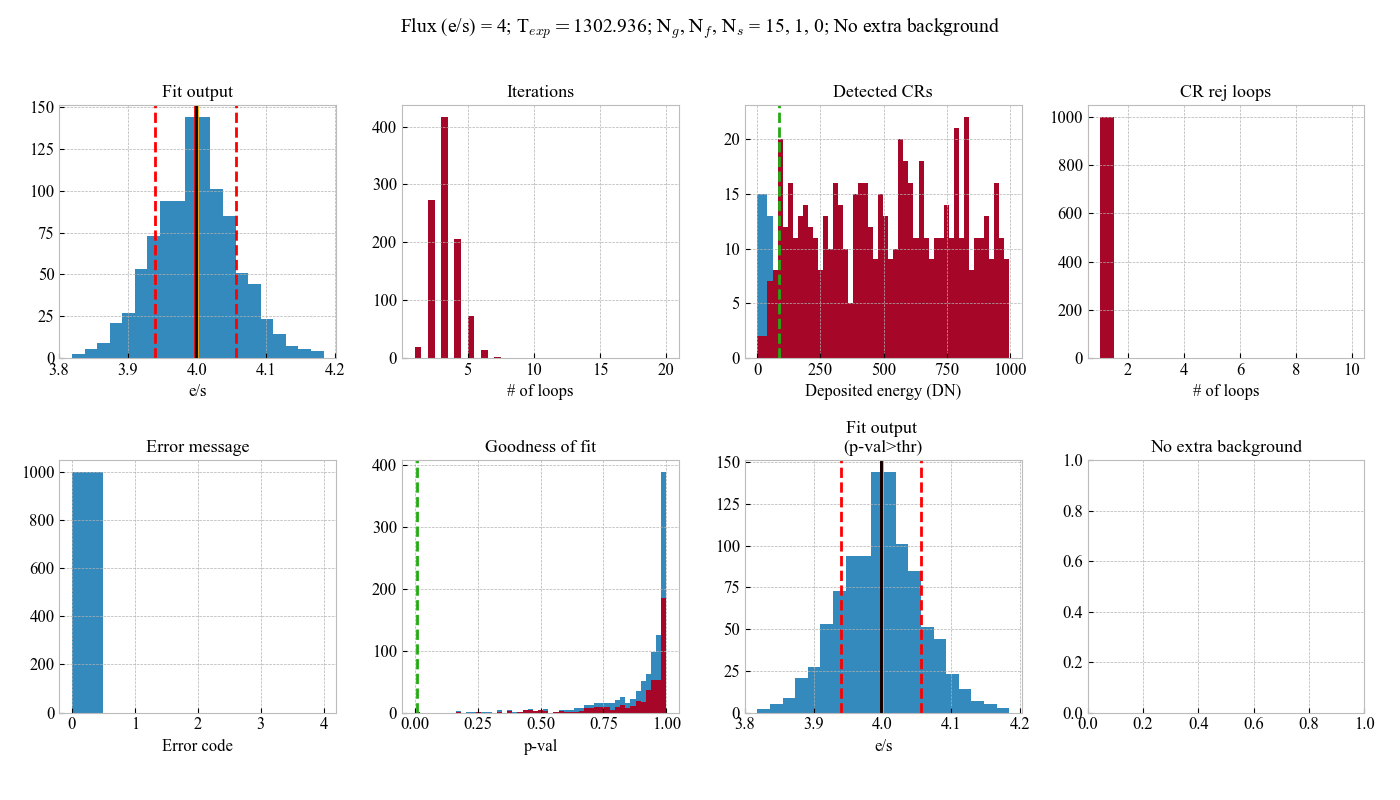

######################
Input flux (e/s): 4
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  1.385,  0.078,  0.002,   1.39
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0554,  0.0031,  0.0001,  0.0555
Standard deviation from "noiseless" counts (e/s):  0.0539
 
Output mean (e/s):  3.9979
Output median (e/s):  3.9985
Output standard deviation (e/s):  0.0585
Rel. % error: :  1.46
Rel. % bias:: -0.05
 
no-CR Output mean (e/s):  3.9957
no-CR Output median (e/s):  3.9971
no-CR Output standard deviation (e/s):  0.0572
no-CR Rel. % error: :  1.43
no-CR Rel. % bias:: -0.11
 
yes-CR Output mean (e/s):  4.0004
yes-CR Output median (e/s):  4.0013
yes-CR Output standard deviation (e/s):  0.0597
yes-CR Rel. % error: :  1.49
yes-CR Rel. % bias::  0.01
 
Fraction of good fits at  0.010 confidence: 99.9 %


<IPython.core.display.Javascript object>


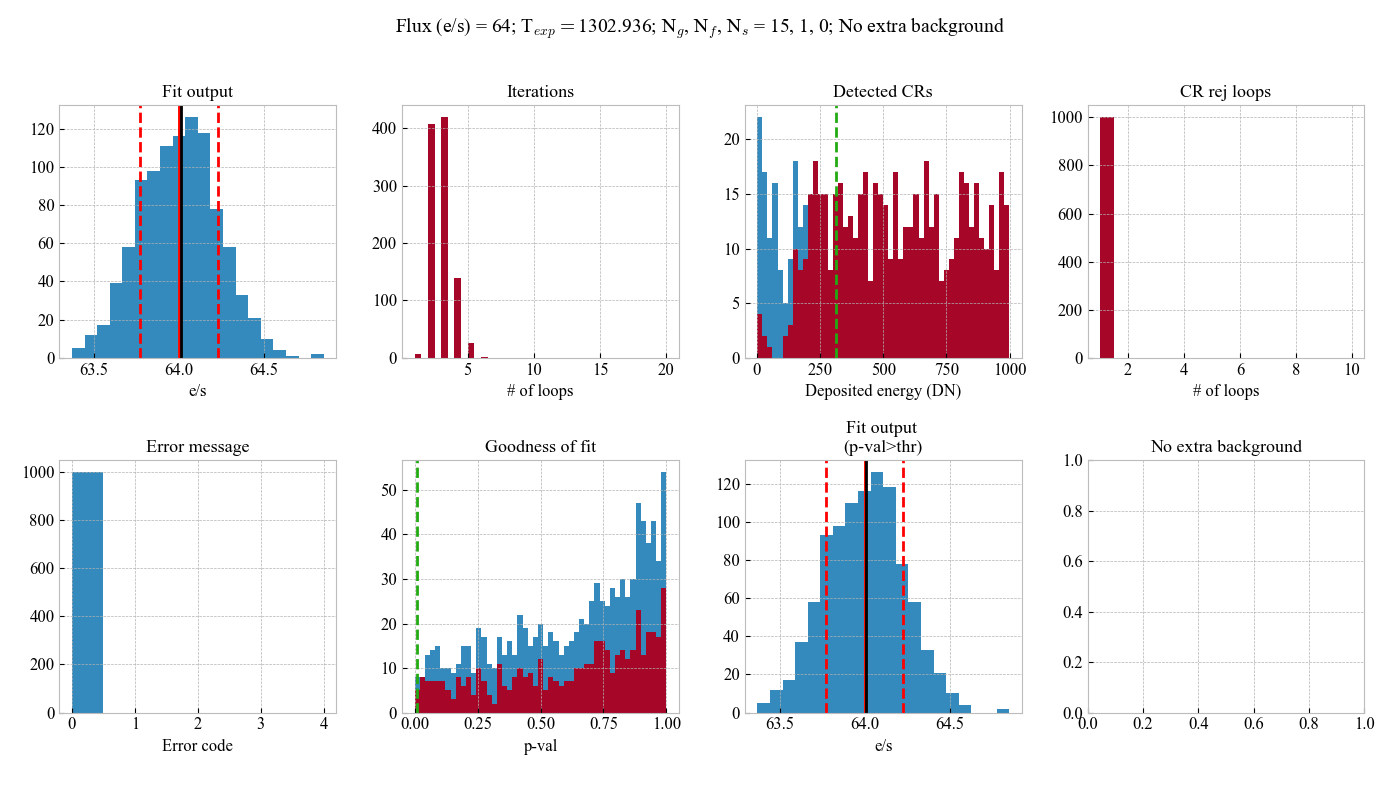

######################
Input flux (e/s): 64
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  0.346,  0.005,  0.000,  0.346
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.2216,  0.0031,  0.0001,  0.2217
Standard deviation from "noiseless" counts (e/s):  0.2148
 
Output mean (e/s): 64.0005
Output median (e/s): 64.0084
Output standard deviation (e/s):  0.2292
Rel. % error: :  0.36
Rel. % bias::  0.00
 
no-CR Output mean (e/s): 63.9854
no-CR Output median (e/s): 64.0033
no-CR Output standard deviation (e/s):  0.2168
no-CR Rel. % error: :  0.34
no-CR Rel. % bias:: -0.02
 
yes-CR Output mean (e/s): 64.0168
yes-CR Output median (e/s): 64.0191
yes-CR Output standard deviation (e/s):  0.2407
yes-CR Rel. % error: :  0.38
yes-CR Rel. % bias::  0.03
 
Fraction of good fits at  0.010 confidence: 99.6 %

<IPython.core.display.Javascript object>


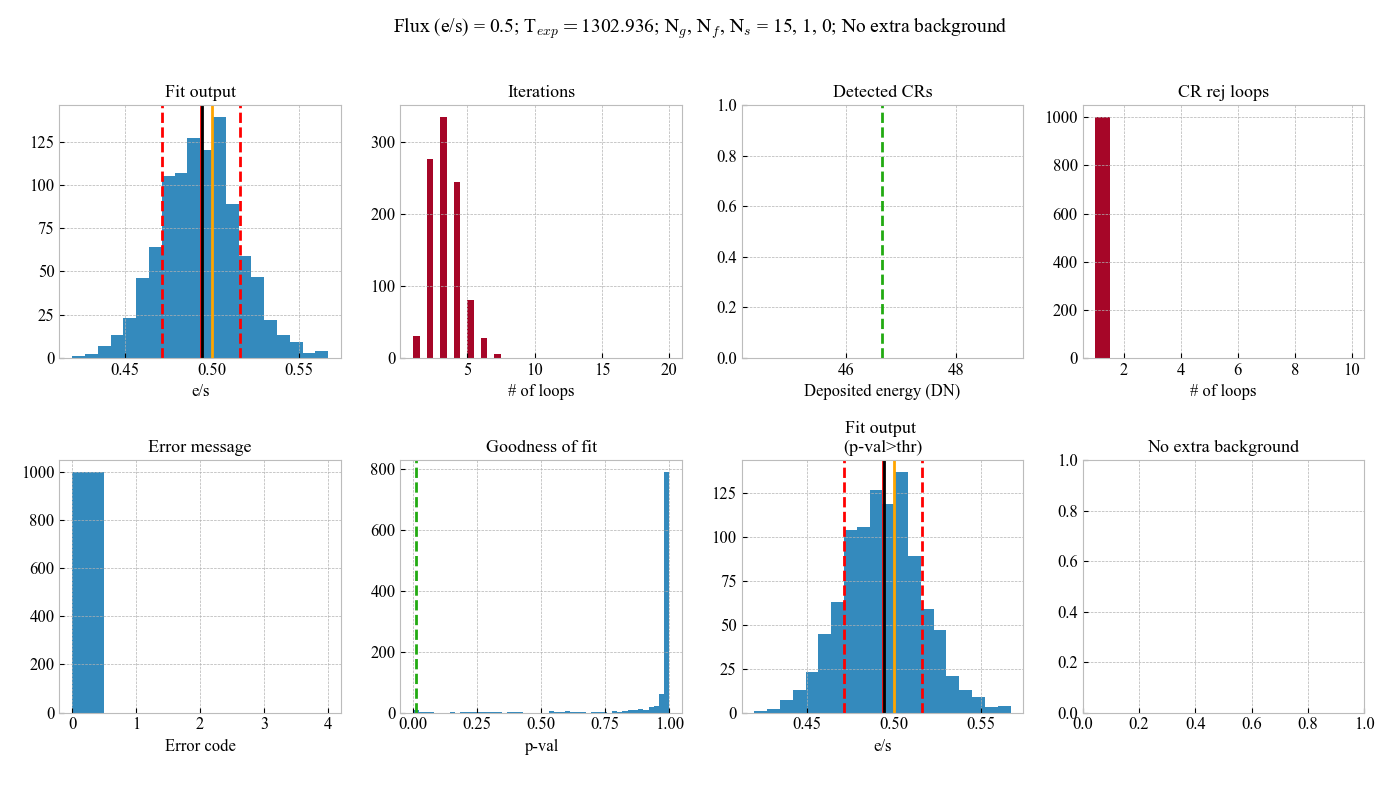

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0190
 
Output mean (e/s):  0.4937
Output median (e/s):  0.4940
Output standard deviation (e/s):  0.0225
Rel. % error: :  4.50
Rel. % bias:: -1.26
 
no-CR Output mean (e/s):  0.4937
no-CR Output median (e/s):  0.4940
no-CR Output standard deviation (e/s):  0.0225
no-CR Rel. % error: :  4.50
no-CR Rel. % bias:: -1.26
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 99.2 

<IPython.core.display.Javascript object>


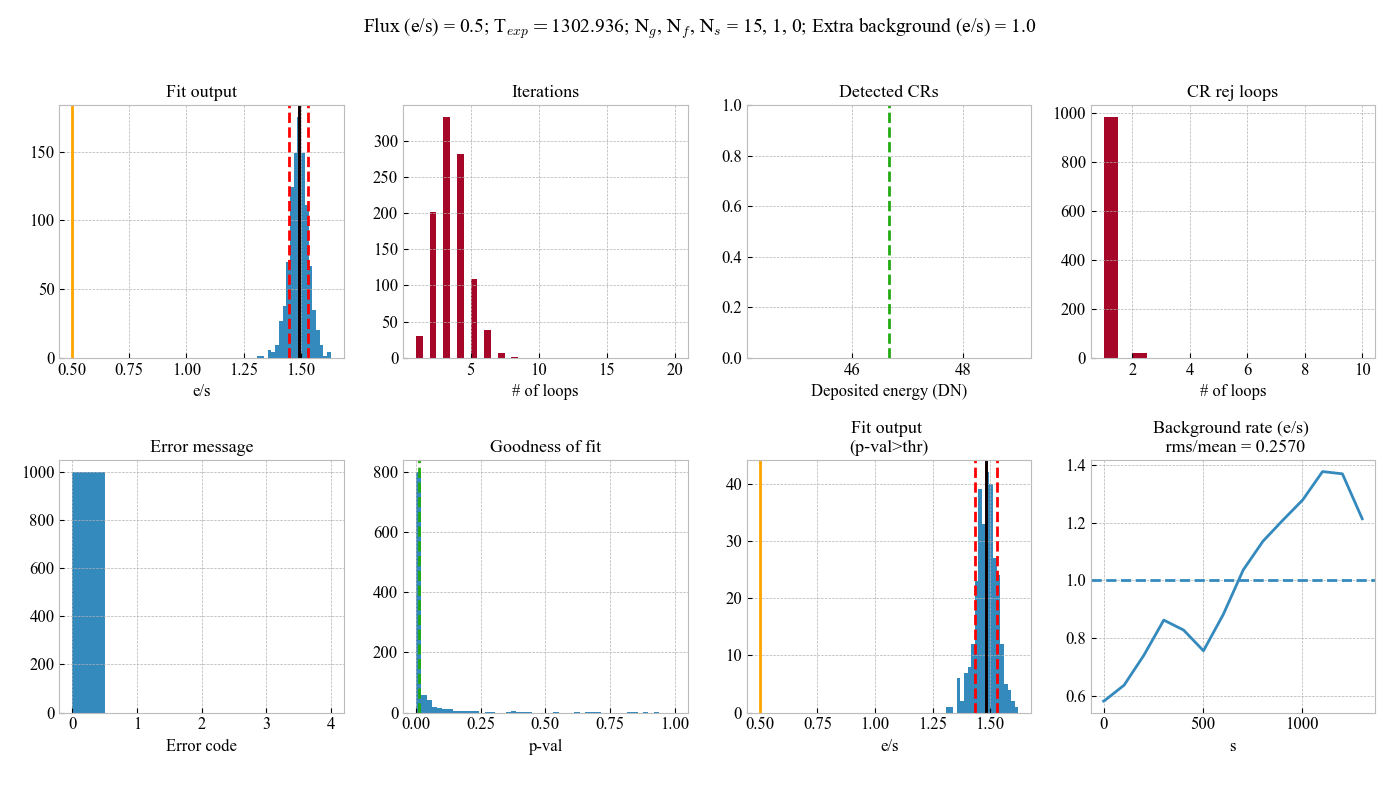

######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0343
 
Output mean (e/s):  1.4917
Output median (e/s):  1.4924
Output standard deviation (e/s):  0.0414
Rel. % error: :  8.29
Rel. % bias:: 198.34
 
no-CR Output mean (e/s):  1.4917
no-CR Output median (e/s):  1.4924
no-CR Output standard deviation (e/s):  0.0414
no-CR Rel. % error: :  8.29
no-CR Rel. % bias:: 198.34
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 28.

<IPython.core.display.Javascript object>


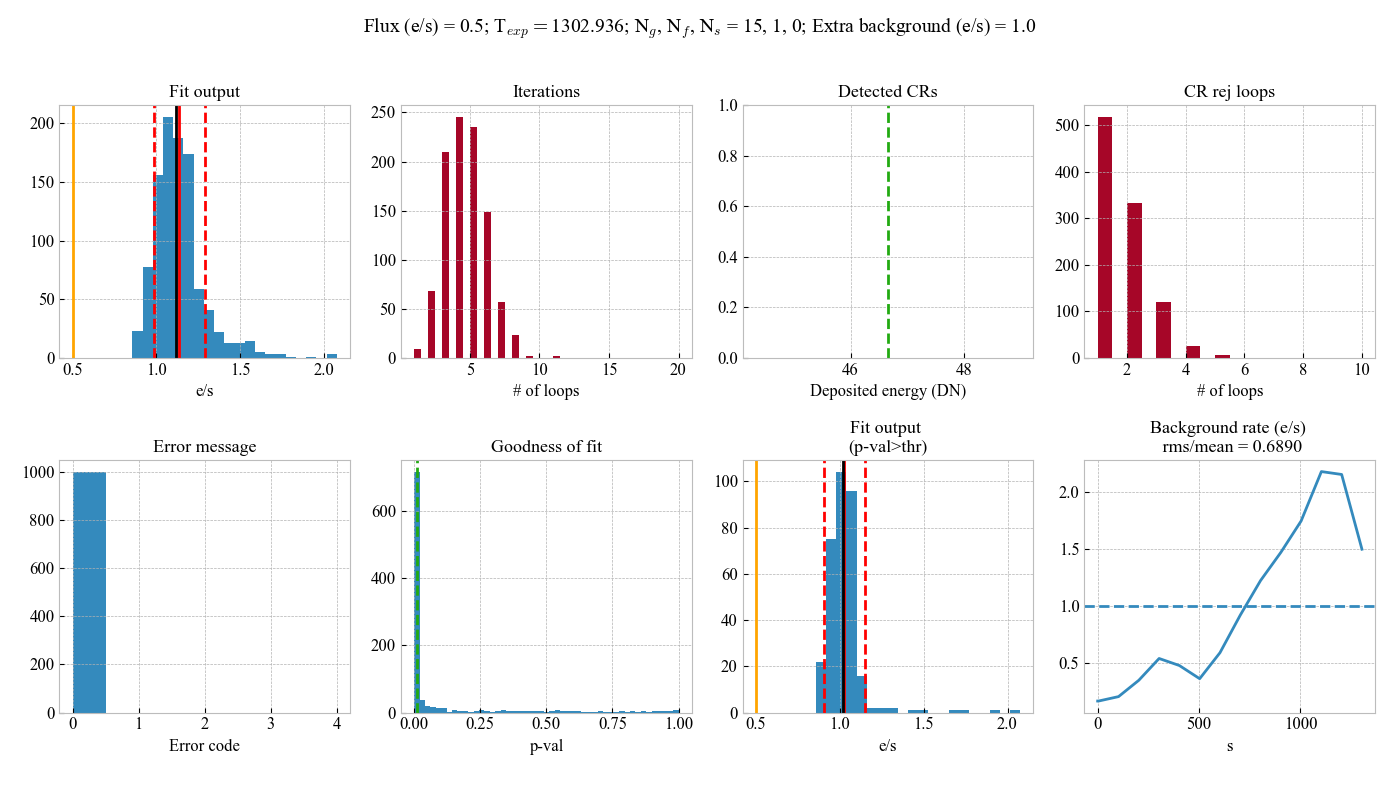

######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0353
 
Output mean (e/s):  1.1346
Output median (e/s):  1.1154
Output standard deviation (e/s):  0.1520
Rel. % error: : 30.40
Rel. % bias:: 126.93
 
no-CR Output mean (e/s):  1.1346
no-CR Output median (e/s):  1.1154
no-CR Output standard deviation (e/s):  0.1520
no-CR Rel. % error: : 30.40
no-CR Rel. % bias:: 126.93
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 32.

<IPython.core.display.Javascript object>


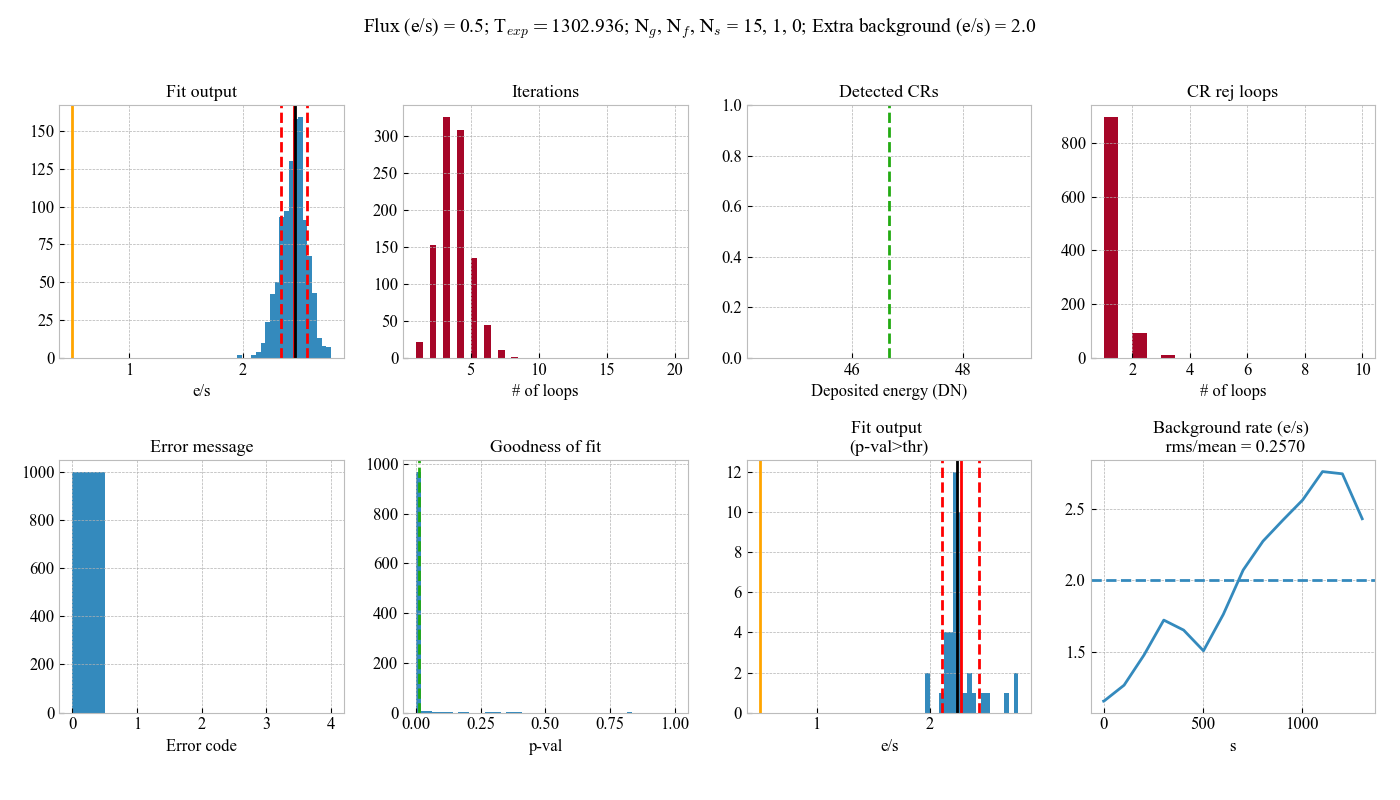

######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0431
 
Output mean (e/s):  2.4499
Output median (e/s):  2.4638
Output standard deviation (e/s):  0.1143
Rel. % error: : 22.86
Rel. % bias:: 389.98
 
no-CR Output mean (e/s):  2.4499
no-CR Output median (e/s):  2.4638
no-CR Output standard deviation (e/s):  0.1143
no-CR Rel. % error: : 22.86
no-CR Rel. % bias:: 389.98
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 4.2

In [9]:
for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    
    BM0 = (error[:,j] == 0)
    mn = np.mean(outerate[BM0,j])
    md = np.median(outerate[BM0,j])
    st = np.std(outerate[BM0,j])

    f = plt.figure(figsize=(14,8))
    
    ax1 = f.add_subplot(241)
    ax1.hist(outerate[BM0,j],bins=20)
    ax1.axvline(myflux,color='orange')
    ax1.axvline(mn,color='red')
    ax1.axvline(mn-st,color='red',linestyle='--')
    ax1.axvline(mn+st,color='red',linestyle='--')
    ax1.axvline(md,color='black')
    ax1.set_title('Fit output',fontsize=13)
    ax1.set_xlabel('e/s')

    ax2 = f.add_subplot(242)
    n,b,p = ax2.hist(counter[:,j],bins=np.linspace(1,20,39))
    n,b,p = ax2.hist(counter[BM0,j],bins=b)
    ax2.set_title('Iterations',fontsize=13)
    ax2.set_xlabel('# of loops')
    
    rCRs = ramps_with_CRs[j]
    BM2 = BM0 & (~rCRs)
    mn2 = np.mean(outerate[BM2,j])
    md2 = np.median(outerate[BM2,j])
    st2 = np.std(outerate[BM2,j])

    BM3 = BM0 & rCRs
    mn3 = np.mean(outerate[BM3,j])
    md3 = np.median(outerate[BM3,j])
    st3 = np.std(outerate[BM3,j])

    
    ax3 = f.add_subplot(243)
    if allCRcounts[j].size >0 :
        n,b,p = ax3.hist(allCRcounts[j],bins=50)
        if allCRdetect[j].size >0 :
            n,b,p = ax3.hist(allCRcounts[j][allCRdetect[j]],bins=b)
    
    ax3.axvline(4*np.sqrt(myflux*np.mean(myramp.group_times[1:]-myramp.group_times[:-1])+2*np.square(meas_list[j][0].RON_adu)),color='#22aa12',linestyle='--')
    ax3.set_title('Detected CRs',fontsize=13)
    ax3.set_xlabel('Deposited energy (DN)')
    
    ax4 = f.add_subplot(244)
    n,b,p = ax4.hist(crloops_counter[:,j],bins=np.linspace(1,10,19))
    n,b,p = ax4.hist(crloops_counter[BM0,j],bins=b)
    ax4.set_title('CR rej loops',fontsize=13)
    ax4.set_xlabel('# of loops')

    ax5 = f.add_subplot(245)
    n,b,p = ax5.hist(error[:,j],bins=np.linspace(0,4,9))
    ax5.set_title('Error message',fontsize=13) 
    ax5.set_xlabel('Error code')

    ax6 = f.add_subplot(246)   
    pthr = 0.01
    n,b,p = ax6.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j])],bins=np.linspace(0,1,50))
    n,b,p = ax6.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j]) & (np.asarray([kk is not None for kk in CR_list[j]]))],bins=np.linspace(0,1,50))
#    n,b,p = ax6.hist(gof_stat[:,j]/(np.sum(gi_list[j],axis=1)-1),bins=np.linspace(0,3,50))
#    n,b,p = ax6.hist(gof_stat[:,j],bins=50)
#    ax6.scatter(gof_pval[:,j],gof_stat[:,j])
    
    ax6.set_title('Goodness of fit',fontsize=13)
    ax6.axvline(pthr,color='#22aa12',linestyle='--')
    ax6.set_xlabel('p-val')

    
    
    BMpt = gof_pval[:,j] > pthr
    
    BM1 = BM0 & BMpt
    mn1 = np.mean(outerate[BM1,j])
    md1 = np.median(outerate[BM1,j])
    st1 = np.std(outerate[BM1,j])

    
    ax7 = f.add_subplot(247)
    ax7.hist(outerate[BM1,j],bins=20)
    ax7.axvline(myflux,color='orange')
    ax7.axvline(mn1,color='red')
    ax7.axvline(mn1-st1,color='red',linestyle='--')
    ax7.axvline(mn1+st1,color='red',linestyle='--')
    ax7.axvline(md1,color='black')
    ax7.set_title('Fit output \n(p-val>thr)',fontsize=13)
    ax7.set_xlabel('e/s')

    ax8 = f.add_subplot(248)

    if mybgs[j] is not None:
        mean_bg_electron_rate = mybgs[j]['mean_bg_er']
        bg_times = mybgs[j]['times']
        bg_electron_rate = mybgs[j]['vbg_er']

        bg_int = interp1d(bg_times,bg_electron_rate,'quadratic')
        varbg = bg_int(myramps[j].read_times)

        dt = myramp.read_times[-1]-myramp.read_times[0]
        t_avg = np.trapz(varbg,myramps[j].read_times) / dt
        varbg = varbg/t_avg * mean_bg_electron_rate
        a_rms = np.sqrt(np.trapz(np.square(varbg-mean_bg_electron_rate),myramps[j].read_times)/dt)

        ax8.set_title('Background rate (e/s) \n rms/mean ={:7.4f}'.format(a_rms/mean_bg_electron_rate),fontsize=13)
        ax8.set_xlabel('s')
        ax8.plot(myramp.read_times,varbg);
        ax8.axhline(mean_bg_electron_rate,linestyle='--')
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{g}}$, N$_{{f}}$, N$_{{s}}$ = {}, {}, {}; Extra background (e/s) = {}'.format(myflux,myramp.group_times[-1],myramp.ngroups,myramp.nframes,myramp.nskips,mean_bg_electron_rate)
    else:
        ax8.set_title('No extra background',fontsize=13)
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{g}}$, N$_{{f}}$, N$_{{s}}$ = {}, {}, {}; No extra background'.format(myflux,myramp.group_times[-1],myramp.ngroups,myramp.nframes,myramp.nskips)
        
        
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
        ax.set_axis_bgcolor('#FFFFFF')

    
    f.suptitle(sts, fontsize=14)
    f.tight_layout(rect=[0,0.03,1,.92])

    
    actual_counts = np.empty(len(meas_list[j]))
    for k in range(actual_counts.size):
        actual_counts[k] = meas_list[j][k].noiseless_counts[-1]
    
    
    exptime = myramp.group_times[-1] - myramp.group_times[0] 
    mean_signal = myflux * exptime
    poi_err = np.sqrt(mean_signal)
    act_poi_err = np.std(actual_counts)*meas_list[j][0].gain
    
    eff_RON = meas_list[j][0].effRON_e
    eff_qerr = np.sqrt(meas_list[j][0].gain*myramp.nframes/12) * eff_RON/meas_list[j][0].RON_e

    tot_noise = np.sqrt(np.sum(np.square(np.array([poi_err,eff_RON,eff_qerr]))))


    
    print('######################')
    print('Input flux (e/s):',myflux)
    print('Exposure time',exptime)
    print('Number of groups / frames / skips: {} / {} / {}'.format(myramp.ngroups,myramp.nframes,myramp.nskips))
    print('Number of tests:',ntest)
    print('Fraction of good fits:',100.*BM0.sum().astype(np.float_)/ntest,'%')
    print(' ')    
    print('Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: {:6.3f}, {:6.3f}, {:6.3f}, {:6.3}'.format(
        100.*poi_err/mean_signal, 100.*eff_RON/mean_signal, 100.*eff_qerr/mean_signal, 100*tot_noise/mean_signal))
    print('Pure Poisson / eff. RON / eff. quantization error / total error [e/s]: {:7.4f}, {:7.4f}, {:7.4f}, {:7.4f}'.format(
        poi_err/exptime, eff_RON/exptime, eff_qerr/exptime, tot_noise/exptime))
    print('Standard deviation from "noiseless" counts (e/s): {:7.4f}'.format(act_poi_err/exptime))
    print(' ')
    print('Output mean (e/s): {:7.4f}'.format(mn))
    print('Output median (e/s): {:7.4f}'.format(md))
    print('Output standard deviation (e/s): {:7.4f}'.format(st))
    print('Rel. % error: : {:5.2f}'.format(100.*st/myflux))
    print('Rel. % bias:: {:5.2f}'.format(100.*(mn-myflux)/myflux))
    print(' ')
    print('no-CR Output mean (e/s): {:7.4f}'.format(mn2))
    print('no-CR Output median (e/s): {:7.4f}'.format(md2))
    print('no-CR Output standard deviation (e/s): {:7.4f}'.format(st2))
    print('no-CR Rel. % error: : {:5.2f}'.format(100.*st2/myflux))
    print('no-CR Rel. % bias:: {:5.2f}'.format(100.*(mn2-myflux)/myflux))
    print(' ')
    print('yes-CR Output mean (e/s): {:7.4f}'.format(mn3))
    print('yes-CR Output median (e/s): {:7.4f}'.format(md3))
    print('yes-CR Output standard deviation (e/s): {:7.4f}'.format(st3))
    print('yes-CR Rel. % error: : {:5.2f}'.format(100.*st3/myflux))
    print('yes-CR Rel. % bias:: {:5.2f}'.format(100.*(mn3-myflux)/myflux))
    print(' ')
    print('Fraction of good fits at {:6.3f} confidence: {} %'.format(pthr,100.*np.sum(BMpt)/len(BMpt)))
    print('p-flagged Output mean (e/s) {:7.4f}'.format(mn1))
    print('p-flagged Output median (e/s) {:7.4f}'.format(md1))
    print('p-flagged Output standard deviation (e/s) {:7.4f}'.format(st1))
    print('p-flagged Rel. % error: {:5.2f}'.format(100.*st1/myflux))
    print('p-flagged Rel. % bias: {:5.2f}'.format(100.*(mn1-myflux)/myflux))
    print(' ')
    print('CR hits / detected',len(allCRcounts[j]),'/',np.sum(allCRdetect[j]))
    print('CR - false positives',np.sum(CR_false_positives[j]))
    

#### Detailed plots to examine the false positive cases

#### Detailed plots to examine the bad fit (ERR > 0) cases

<IPython.core.display.Javascript object>


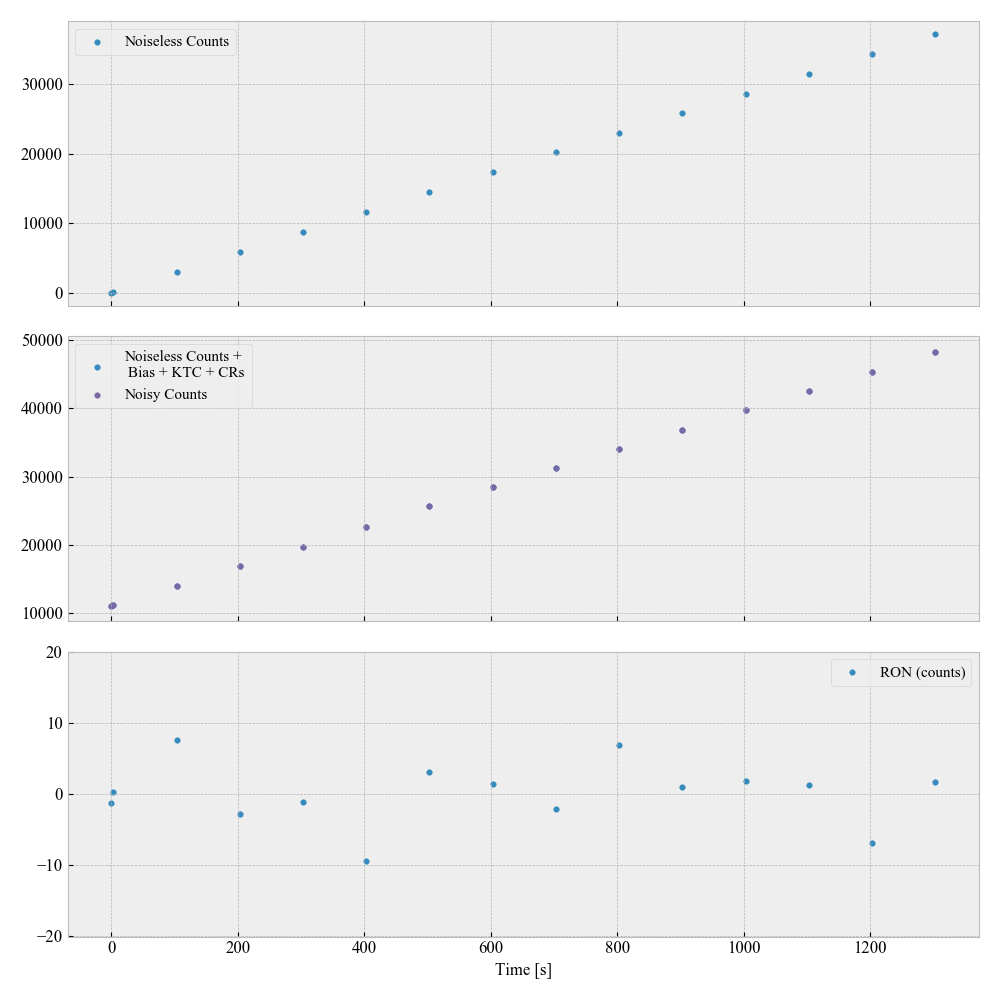

0.00089999999999999998

In [18]:
meas_h = meas_list[2][947]
meas_h.test_plot()

gof_pval[947,2]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True] 3 0 1 63.6507400557 -90.7513056156 0.0008
0.0008


<IPython.core.display.Javascript object>


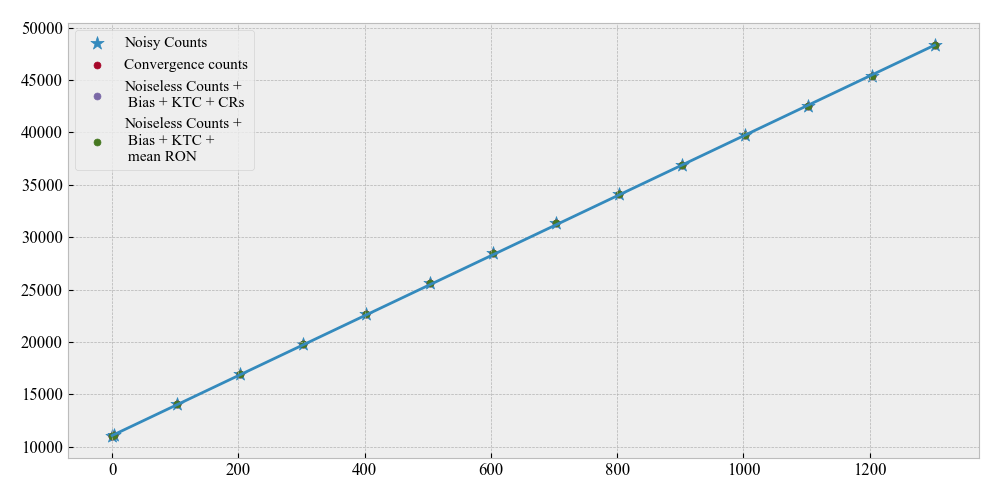

In [22]:
from ramp_utils.fitter import IterativeFitter
fitter = IterativeFitter(meas_h)
error,counter, goodints, crloops_counter  = fitter.perform_fit()
outerate = fitter.mean_electron_rate
fitter.goodness_of_fit(mode='poisson-likelihood')
gof_stat_h = fitter.gof_stat
gof_pval_h = fitter.gof_pval


print(goodints,counter,error,crloops_counter,outerate,gof_stat_h,gof_pval_h)
print(gof_pval_h)

fitter.test_plot()

In [24]:
(meas_h.electrons_reads[1:]-meas_h.electrons_reads[:-1])/(meas_h.RTS.read_times[1:]-meas_h.RTS.read_times[:-1])




array([ 65.14324693,  64.20935791,  63.96      ,  63.75      ,
        64.03935961,  66.57      ,  62.28      ,  64.24935751,
        61.14      ,  62.64      ,  63.22936771,  62.89      ,
        62.68      ,  65.73      ])

In [43]:
from scipy.stats import poisson
for i in range(len(meas_h.electrons_reads[1:])):
    mu = 64*(meas_h.RTS.read_times[i+1]-meas_h.RTS.read_times[i])
    kappa = meas_h.electrons_reads[i+1]-meas_h.electrons_reads[i]    
    print('{:9.4f} {:9.4f} {:4d} {:9.4f} {:9.4f}'.format(mu, np.sqrt(mu), kappa,  (mu-kappa)/np.sqrt(mu), poisson.logpmf(kappa,mu)))

 187.6480   13.6985  191   -0.2447   -3.5753
6400.0640   80.0004 6421   -0.2617   -5.3368
6400.0000   80.0000 6396    0.0500   -5.3019
6400.0000   80.0000 6375    0.3125   -5.3479
6400.0640   80.0004 6404   -0.0492   -5.3025
6400.0000   80.0000 6657   -3.2125  -10.4130
6400.0000   80.0000 6228    2.1500   -7.6196
6400.0640   80.0004 6425   -0.3117   -5.3514
6400.0000   80.0000 6114    3.5750  -11.7658
6400.0000   80.0000 6264    1.7000   -6.7456
6400.0640   80.0004 6323    0.9633   -5.7608
6400.0000   80.0000 6289    1.3875   -6.2604
6400.0000   80.0000 6268    1.6500   -6.6613
6400.0000   80.0000 6573   -2.1625   -7.6317


In [44]:
covmat_h    = fitter.covmat[np.ix_(fitter.good_intervals,fitter.good_intervals)]
invcovmat_h = np.linalg.inv(covmat_h)
sigmasq_h   = 1./np.sum(invcovmat_h)

print(np.sqrt(sigmasq_h))

0.153342667871
